# Keplerian satellite orbit
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example demonstrates the basic propagation of a (quasi-massless) body under the influence of a central point-mass attractor. It therefore resembles the classic two-body problem.

Due to the quasi-massless nature of the propagated body, no accelerations have to be modelled on the central body, which is therefore not propagated.
As one expects from this setup, the trajectory of the propagated quasi-massless body describes a Keplerian orbit.

Amongst others, the example showcases the creation of bodies using properties from standard SPICE data `get_default_body_settings()` as well as the element conversion functionalities `keplerian_to_cartesian_elementwise()` of tudat.
It also demonstrates how the results of the propagation can be accessed and processed.

## Import statements
The required import statements are made here, at the very beginning.

Some standard modules are first loaded: `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported.

In [1]:
# Load standard modules
import numpy as np
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup, propagation_setup
from tudatpy.kernel.astro import element_conversion
from tudatpy.kernel import constants
from tudatpy.util import result2array

## Configuration
NAIF's `SPICE` kernels are first loaded, so that the position of various bodies such as the Earth can be make known to `tudatpy`.

Then, the start and end simulation epochs are setups. In this case, the start epoch is set to `0`, corresponding to the 1st of January 2000.
The end epoch is defined as 1 day later.
The times should be specified in seconds since J2000.
Please refer to the API documentation of the `time_conversion module` [here](https://tudatpy.readthedocs.io/en/latest/time_conversion.html) for more information on this.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
simulation_start_epoch = 0.0
simulation_end_epoch = constants.JULIAN_DAY

## Environment setup
Let’s create the environment for our simulation. This setup covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create the bodies
Bodies can be created by making a list of strings with the bodies that is to be included in the simulation.

The default body settings (such as atmosphere, body shape, rotation model) are taken from `SPICE`.

These settings can be adjusted. Please refere to the [Available Environment Models](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/environment_setup/create_models/available.html#available-environment-models) in the user guide for more details.

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [3]:
# Create default body settings for "Earth"
bodies_to_create = ["Earth"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create system of bodies (in this case only Earth)
bodies = environment_setup.create_system_of_bodies(body_settings)

### Create the vehicle
Let's now create the massless satellite for which the orbit around Earth will be propagated.

In [4]:
# Add vehicle object to system of bodies
bodies.create_empty_body("Delfi-C3")

## Propagation setup
Now that the environment is created, the propagation setup is defined.

First, the bodies to be propagated and the central bodies will be defined.
Central bodies are the bodies with respect to which the state of the respective propagated bodies is defined.

In [5]:
# Define bodies that are propagated
bodies_to_propagate = ["Delfi-C3"]

# Define central bodies of propagation
central_bodies = ["Earth"]

### Create the acceleration model
First off, the acceleration settings that act on `Delfi-C3` are to be defined.
In this case, these simply consist in the Earth gravitational effect modelled as a point mass.

The acceleration settings defined are then applied to `Delfi-C3` in a dictionary.

This dictionary is finally input to the propagation setup to create the acceleration models.

In [6]:
# Define accelerations acting on Delfi-C3
acceleration_settings_delfi_c3 = dict(
    Earth=[propagation_setup.acceleration.point_mass_gravity()]
)

acceleration_settings = {"Delfi-C3": acceleration_settings_delfi_c3}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

### Define the initial state
The initial state of the vehicle that will be propagated is now defined. 

This initial state always has to be provided as a cartesian state, in the form of a list with the first three elements reprensenting the initial position, and the three remaining elements representing the initial velocity.

In this case, let's make use of the `keplerian_to_cartesian_elementwise()` function that is included in the `element_conversion` module, so that the initial state can be input as Keplerian elements, and then converted in Cartesian elements.

In [7]:
# Set initial conditions for the satellite that will be
# propagated in this simulation. The initial conditions are given in
# Keplerian elements and later on converted to Cartesian elements
earth_gravitational_parameter = bodies.get("Earth").gravitational_parameter
initial_state = element_conversion.keplerian_to_cartesian_elementwise(
    gravitational_parameter=earth_gravitational_parameter,
    semi_major_axis=7500.0e3,
    eccentricity=0.1,
    inclination=np.deg2rad(85.3),
    argument_of_periapsis=np.deg2rad(235.7),
    longitude_of_ascending_node=np.deg2rad(23.4),
    true_anomaly=np.deg2rad(139.87),
)

### Create the propagator settings
The propagator is finally setup.

First, a termination condition is defined so that the propagation will stop when the end epochs that was defined is reached.

Subsequently, the integrator settings are defined using a RK4 integrator with the fixed step size of 10 seconds.

Then, the translational propagator settings are defined. These are used to simulate the orbit of `Delfi-C3` around Earth.

In [20]:
# Create termination settings
termination_settings = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create numerical integrator settings
fixed_step_size = 10.0
integrator_settings = propagation_setup.integrator.runge_kutta_4(fixed_step_size)

# Also save orbital elements
dependent_variables_to_save = [
    propagation_setup.dependent_variable.keplerian_state("Delfi-C3", "Earth")
]

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_settings,
    output_variables=dependent_variables_to_save
)

## Propagate the orbit
The orbit is now ready to be propagated.

This is done by calling the `create_dynamics_simulator()` function of the `numerical_simulation module`.
This function requires the `bodies` and `propagator_settings` that have all been defined earlier.

After this, the history of the propagated state over time, containing both the position and velocity history, is extracted.
This history, taking the form of a dictionary, is then converted to an array containing 7 columns:
- Column 0: Time history, in seconds since J2000.
- Columns 1 to 3: Position history, in meters, in the frame that was specified in the `body_settings`.
- Columns 4 to 6: Velocity history, in meters per second, in the frame that was specified in the `body_settings`.

In [23]:
# Create simulation object and propagate the dynamics
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies, propagator_settings
)

# Extract the resulting state history and convert it to an ndarray
states = dynamics_simulator.state_history
states_array = result2array(states)

# For the orbital elements
dep_vars = dynamics_simulator.dependent_variable_history
dep_vars_array = result2array(dep_vars)

## Post-process the propagation results
The results of the propagation are then processed to a more user-friendly form.

### Print initial and final states
First, let's print the initial and final position and velocity vector of `Delfi-C3`.

In [24]:
print(
    f"""
Single Earth-Orbiting Satellite Example.
The initial position vector of Delfi-C3 is [km]: \n{
    states[simulation_start_epoch][:3] / 1E3} 
The initial velocity vector of Delfi-C3 is [km/s]: \n{
    states[simulation_start_epoch][3:] / 1E3}
\nAfter {simulation_end_epoch} seconds the position vector of Delfi-C3 is [km]: \n{
    states[simulation_end_epoch][:3] / 1E3}
And the velocity vector of Delfi-C3 is [km/s]: \n{
    states[simulation_end_epoch][3:] / 1E3}
    """
)


Single Earth-Orbiting Satellite Example.
The initial position vector of Delfi-C3 is [km]: 
[7037.48400133 3238.05901792 2150.7241875 ] 
The initial velocity vector of Delfi-C3 is [km/s]: 
[-1.46565763 -0.04095839  6.62279761]

After 86400.0 seconds the position vector of Delfi-C3 is [km]: 
[-4560.45416186 -1438.31830649  5973.9910758 ]
And the velocity vector of Delfi-C3 is [km/s]: 
[-4.55021345 -2.41254418 -4.95063039]
    


### Visualise the trajectory
Finally, let's plot the trajectory of `Delfi-C3` around Earth in 3D.

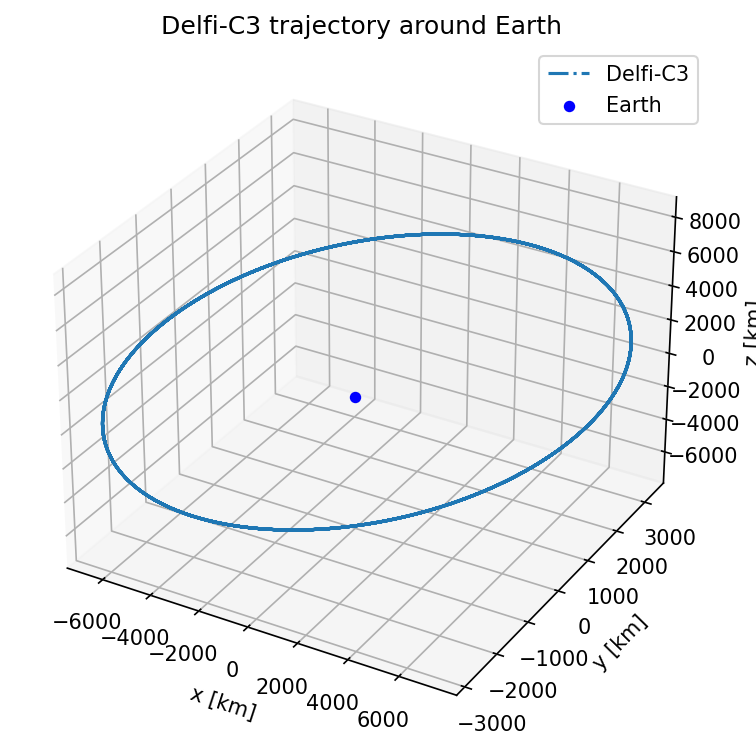

In [25]:
# Define a 3D figure using pyplot
fig = plt.figure(figsize=(6,6), dpi=150)
ax = fig.add_subplot(111, projection='3d')
ax.set_title(f'Delfi-C3 trajectory around Earth')

# Plot the positional state history
ax.plot(states_array[:, 1]/1E3, states_array[:, 2]/1E3, states_array[:, 3]/1E3, label=bodies_to_propagate[0], linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')

# Add the legend and labels, then show the plot
ax.legend()
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')
plt.show()

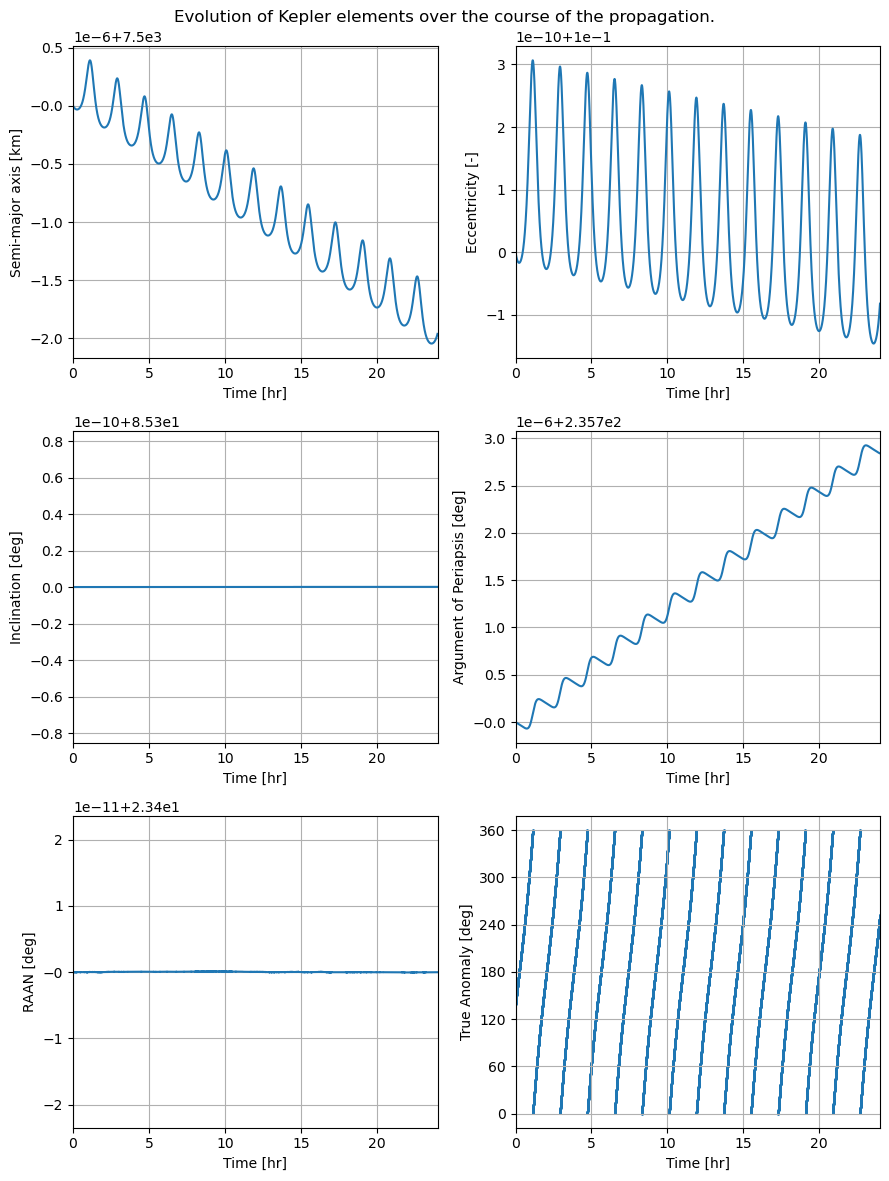

In [30]:
# Plot Kepler elements as a function of time
time_hours = dep_vars_array[:,0]/3600
kepler_elements = dep_vars_array[:,1:7]
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(9, 12))
fig.suptitle('Evolution of Kepler elements over the course of the propagation.')

# Semi-major Axis
semi_major_axis = kepler_elements[:,0] / 1e3
ax1.plot(time_hours, semi_major_axis)
ax1.set_ylabel('Semi-major axis [km]')

# Eccentricity
eccentricity = kepler_elements[:,1]
ax2.plot(time_hours, eccentricity)
ax2.set_ylabel('Eccentricity [-]')

# Inclination
inclination = np.rad2deg(kepler_elements[:,2])
ax3.plot(time_hours, inclination)
ax3.set_ylabel('Inclination [deg]')

# Argument of Periapsis
argument_of_periapsis = np.rad2deg(kepler_elements[:,3])
ax4.plot(time_hours, argument_of_periapsis)
ax4.set_ylabel('Argument of Periapsis [deg]')

# Right Ascension of the Ascending Node
raan = np.rad2deg(kepler_elements[:,4])
ax5.plot(time_hours, raan)
ax5.set_ylabel('RAAN [deg]')

# True Anomaly
true_anomaly = np.rad2deg(kepler_elements[:,5])
ax6.scatter(time_hours, true_anomaly, s=1)
ax6.set_ylabel('True Anomaly [deg]')
ax6.set_yticks(np.arange(0, 361, step=60))

for ax in fig.get_axes():
    ax.set_xlabel('Time [hr]')
    ax.set_xlim([min(time_hours), max(time_hours)])
    ax.grid()
plt.tight_layout()